In [5]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from torch.utils.data import Dataset
import os
import random
import math
from PIL import Image
from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [6]:
class ExpressionEncoder(nn.Module):
    def __init__(self, feature_dim=128, pretrained=False):
        super().__init__()
        base = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

        # Modify first conv to accept grayscale (1 channel)
        base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)

        # Remove the final FC layer and avgpool
        self.backbone = nn.Sequential(*list(base.children())[:-2])  # outputs [B, 512, 7, 7]
        self.pool = nn.AdaptiveAvgPool2d((1, 1))                    # for global feature
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, feature_dim)                       # final embedding layer

    def forward(self, x):
        feat_map = self.backbone(x)         # [B, 512, 7, 7]
        pooled = self.pool(feat_map)        # [B, 512, 1, 1]
        global_feat = self.fc(self.flatten(pooled))  # [B, feature_dim]
        return global_feat, feat_map

In [7]:
class StatisticsNetwork(nn.Module):
    def __init__(self, input_dim_x, input_dim_z, hidden_dim=512):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim_x + input_dim_z, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, x, z):
        # x: e.g. image (flattened), or patch vector
        # z: e.g. expression embedding
        joint = torch.cat([x, z], dim=1)
        return self.net(joint)

In [8]:
def dv_mi_estimator(joint_samples, marginal_samples, stat_net):
    x_j, z_j = joint_samples
    x_m, z_m = marginal_samples
    
    # Single forward pass if possible
    with torch.no_grad():
        max_val = stat_net(x_m, z_m).max()
    
    T_j = stat_net(x_j, z_j) - max_val
    T_m = stat_net(x_m, z_m) - max_val
    
    # More efficient computation
    log_mean_exp = torch.logsumexp(T_m.flatten(), dim=0) - math.log(T_m.numel())
    return T_j.mean() - log_mean_exp

In [9]:
def extract_patches(feature_map):
    """
    Extract local patches for local MI estimation.
    Input shape: [B, C, H, W]
    Output shape: [B*H*W, C]
    """
    B, C, H, W = feature_map.shape
    return feature_map.permute(0, 2, 3, 1).reshape(B * H * W, C)
def expression_loss(M, N, Eexp, stat_nets,
                    mu_exp=2.0, nu_exp=3.0, delta=0.1):
    """
    Computes expression loss from mutual information and L1 alignment.
    """

    # 1. Expression embeddings and conv feature maps
    EM, FM = Eexp(M)  # EM: [B, 128], FM: [B, 512, 7, 7]
    EN, FN = Eexp(N)

    # 2. Global inputs
    x_M = M.view(M.size(0), -1)
    x_N = N.view(N.size(0), -1)

    # 3. Global MI
    mi_M = dv_mi_estimator((x_M, EN),
                           (x_M[torch.randperm(x_M.size(0))], EN),
                           stat_nets['global_M'])

    mi_N = dv_mi_estimator((x_N, EM),
                           (x_N[torch.randperm(x_N.size(0))], EM),
                           stat_nets['global_N'])

   # Extract local patches
    patches_FM = extract_patches(FM)  # [B * H * W, 512]
    patches_FN = extract_patches(FN)
    
    # Get batch size and patch grid size
    B, C, H, W = FM.shape
    num_patches = H * W
    
    # Correct expansion of EM/EN to match patch dimension
    # EM: [B, 128] → [B * H * W, 128]
    EM_local = EM[:, None, :].expand(B, num_patches, EM.shape[1]).reshape(-1, EM.shape[1])
    EN_local = EN[:, None, :].expand(B, num_patches, EN.shape[1]).reshape(-1, EN.shape[1])

    
    # Sanity check
    assert patches_FM.shape[0] == EN_local.shape[0], f"patches_FM: {patches_FM.shape}, EN_local: {EN_local.shape}"
    assert patches_FN.shape[0] == EM_local.shape[0], f"patches_FN: {patches_FN.shape}, EM_local: {EM_local.shape}"


    # 5. Local MI
    mi_local_M = dv_mi_estimator(
        (patches_FM, EN_local),
        (patches_FM[torch.randperm(patches_FM.size(0))], EN_local),
        stat_nets['local_M']
    )

    mi_local_N = dv_mi_estimator(
        (patches_FN, EM_local),
        (patches_FN[torch.randperm(patches_FN.size(0))], EM_local),
        stat_nets['local_N']
    )

    # 6. L1 similarity
    l1 = torch.mean(torch.abs(EM - EN))

    # 7. Final loss
    Lexp_MI = mu_exp * (mi_M + mi_N) + nu_exp * (mi_local_M + mi_local_N)
    total_loss = -Lexp_MI + delta * l1

    return total_loss

In [9]:
def train_stage1_expression(
    dataloader,
    Eexp,
    stat_nets,
    optimizer,
    device='cuda',
    epochs=10,
    mu_exp=0.5,  # DICE-FER paper value
    nu_exp=1.0,  # DICE-FER paper value
    delta=0.1    # Controls L1 strength
):
    # Move models to device
    Eexp.to(device)
    for net in stat_nets.values():
        net.to(device)

    # Set training mode
    Eexp.train()
    for net in stat_nets.values():
        net.train()
    print("Starting Stage 1: Expression Disentanglement")

    for epoch in range(epochs):
        total_loss = 0.0

        for step, (M, N, _) in enumerate(dataloader):
            M, N = M.to(device), N.to(device)

            # -------- Step 1: Forward pass through expression encoder --------
            EM, FM = Eexp(M)  # [B, 128], [B, 512, 7, 7]
            EN, FN = Eexp(N)

            # -------- Step 2: Global MI Estimation --------
            x_M = M.view(M.size(0), -1)
            x_N = N.view(N.size(0), -1)

            mi_M = dv_mi_estimator((x_M, EN),
                                   (x_M[torch.randperm(x_M.size(0))], EN),
                                   stat_nets['global_M'])

            mi_N = dv_mi_estimator((x_N, EM),
                                   (x_N[torch.randperm(x_N.size(0))], EM),
                                   stat_nets['global_N'])

            # -------- Step 3: Local MI Estimation --------
            patches_FM = extract_patches(FM)  # [B*H*W, 512]
            patches_FN = extract_patches(FN)

            B, C, H, W = FM.shape
            num_patches = H * W

            EM_local = EM[:, None, :].expand(B, num_patches, EM.shape[1]).reshape(-1, EM.shape[1])
            EN_local = EN[:, None, :].expand(B, num_patches, EN.shape[1]).reshape(-1, EN.shape[1])

            mi_local_M = dv_mi_estimator((patches_FM, EN_local),
                                         (patches_FM[torch.randperm(patches_FM.size(0))], EN_local),
                                         stat_nets['local_M'])

            mi_local_N = dv_mi_estimator((patches_FN, EM_local),
                                         (patches_FN[torch.randperm(patches_FN.size(0))], EM_local),
                                         stat_nets['local_N'])

            # -------- Step 4: L1 Similarity --------
            l1 = torch.mean(torch.abs(EM - EN))

            # -------- Step 5: Final Loss --------
            Lexp_MI = mu_exp * (mi_M + mi_N) + nu_exp * (mi_local_M + mi_local_N)
            loss = -Lexp_MI + delta * l1

            # -------- Step 6: Backpropagation --------
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            # Optional: print stats
            if step % 50 == 0:
                print(f"[Epoch {epoch+1} | Step {step}] Loss = {loss.item():.4f} | MI_Global: {mi_M.item():.3f}, {mi_N.item():.3f} | MI_Local: {mi_local_M.item():.3f}, {mi_local_N.item():.3f} | L1: {l1.item():.3f}")

        avg_loss = total_loss / len(dataloader)
        print(f"[Epoch {epoch+1}] Avg Expression Loss: {avg_loss:.6f}")

In [10]:
class ExpressionPairDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.transform = transform
        self.label_to_imgs = {}
        self.labels = []

        # Organize images by expression label
        for label in os.listdir(root_dir):
            folder = os.path.join(root_dir, label)
            if not os.path.isdir(folder):
                continue
            imgs = [os.path.join(folder, f) for f in os.listdir(folder)
                    if f.endswith(('.jpg', '.png'))]
            if len(imgs) >= 2:
                self.label_to_imgs[label] = imgs
                self.labels.append(label)

    def __len__(self):
        return sum(len(imgs) for imgs in self.label_to_imgs.values())

    def __getitem__(self, idx):
        label = random.choice(self.labels)
        img_paths = random.sample(self.label_to_imgs[label], 2)
        img1 = Image.open(img_paths[0]).convert('L')  # grayscale
        img2 = Image.open(img_paths[1]).convert('L')

        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, self.labels.index(label)

In [11]:
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),  # Converts to [C, H, W] with C=1
])


dataset = ExpressionPairDataset(root_dir='../Dataset/Processed_Photos', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [12]:
# Instantiate expression encoder
Eexp = ExpressionEncoder( feature_dim=128,pretrained=False)

# Statistics networks (input_dim_x, input_dim_z)
stat_nets = {
    'global_M': StatisticsNetwork(112*112, 128),   # or 49*49 if pre-pooled
    'global_N': StatisticsNetwork(112*112, 128),
    
    # Local MI networks (patch → embedding)
    'local_M': StatisticsNetwork(512, 128),        # ResNet's conv output is [B, 512, 7, 7]
    'local_N': StatisticsNetwork(512, 128)
}

# Optimizer
optimizer = torch.optim.Adam(
    list(Eexp.parameters()) +
    [p for net in stat_nets.values() for p in net.parameters()],
    lr=1e-4
)
# Your dataloader must yield: (M, N, label) where M and N share same expression
device = 'cuda' if torch.cuda.is_available() else 'cpu'



In [116]:
train_stage1_expression(dataloader, Eexp, stat_nets, optimizer, device=device, epochs=13)
torch.save(Eexp.state_dict(), "expression_encoder.pth")

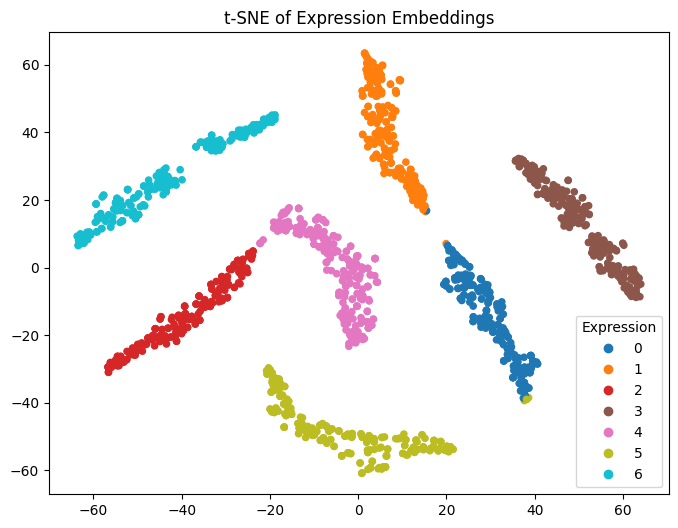

In [10]:
#Visualisation Code
Eexp = ExpressionEncoder(feature_dim=128)
Eexp.load_state_dict(torch.load("expression_encoder.pth", map_location='cpu'))
def visualize_expression_embeddings(Eexp, dataloader, device='cpu'):
    Eexp.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for M, _, label in dataloader:  # Only need one image per pair
            M = M.to(device)
            EM, _ = Eexp(M)
            all_embeddings.append(EM.cpu())
            all_labels.extend(label.cpu().numpy())

    all_embeddings = torch.cat(all_embeddings, dim=0).numpy()

    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    reduced = tsne.fit_transform(all_embeddings)

    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=all_labels, cmap='tab10', s=20)
    plt.title("t-SNE of Expression Embeddings")
    plt.legend(*scatter.legend_elements(), title="Expression")
    plt.show()
visualize_expression_embeddings(Eexp, dataloader, device='cpu')

In [11]:
with torch.no_grad():
    for M, _, _ in dataloader:
        EM, _ = Eexp(M.to('cpu'))  # or 'cuda' if available
        print("STD of EM:", EM.std(dim=0).mean().item())
        break

STD of EM: 1.8846368789672852


In [10]:
class IdentityEncoder(nn.Module):
    def __init__(self, feature_dim=128, pretrained=False):
        super().__init__()
        base = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
        base.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.backbone = nn.Sequential(*list(base.children())[:-2])
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, feature_dim)

    def forward(self, x):
        feat_map = self.backbone(x)
        pooled = self.pool(feat_map)
        identity_feat = self.fc(self.flatten(pooled))
        return identity_feat, feat_map

In [20]:
def identity_loss(M, N, Eid, stat_nets, mu_id=2.0, nu_id=3.0, delta=0.1):
    """
    Computes identity loss using mutual information and L1 dissimilarity.
    """
    # 1. Identity embeddings and conv feature maps
    IM, FM = Eid(M)  # IM: [B, 128], FM: [B, 512, 7, 7]
    IN, FN = Eid(N)

    # 2. Global inputs
    x_M = M.view(M.size(0), -1)
    x_N = N.view(N.size(0), -1)

    # 3. Global MI
    mi_M = dv_mi_estimator((x_M, IN),
                           (x_M[torch.randperm(x_M.size(0))], IN),
                           stat_nets['global_M'])

    mi_N = dv_mi_estimator((x_N, IM),
                           (x_N[torch.randperm(x_N.size(0))], IM),
                           stat_nets['global_N'])

    # 4. Local MI (patches)
    patches_FM = extract_patches(FM)
    patches_FN = extract_patches(FN)

    B, C, H, W = FM.shape
    num_patches = H * W

    IM_local = IM[:, None, :].expand(B, num_patches, IM.shape[1]).reshape(-1, IM.shape[1])
    IN_local = IN[:, None, :].expand(B, num_patches, IN.shape[1]).reshape(-1, IN.shape[1])

    mi_local_M = dv_mi_estimator((patches_FM, IN_local),
                                 (patches_FM[torch.randperm(patches_FM.size(0))], IN_local),
                                 stat_nets['local_M'])

    mi_local_N = dv_mi_estimator((patches_FN, IM_local),
                                 (patches_FN[torch.randperm(patches_FN.size(0))], IM_local),
                                 stat_nets['local_N'])

    # 5. L1 dissimilarity (maximize difference)
    l1 = torch.mean(torch.abs(IM - IN))

    # 6. Final loss (note: we minimize negative MI and maximize dissimilarity)
    Lid_MI = mu_id * (mi_M + mi_N) + nu_id * (mi_local_M + mi_local_N)
    total_loss = -Lid_MI - delta * l1  # note the minus on L1

    return total_loss

In [21]:
def train_stage2_identity(
    dataloader,
    Eid,
    stat_nets,
    optimizer,
    device='cuda',
    epochs=10,
    mu_id=0.5,   # MI weighting
    nu_id=1.0,   # Local MI weighting
    delta=0.1    # L1 dissimilarity weight
):
    # Move models to device
    Eid.to(device)
    for net in stat_nets.values():
        net.to(device)

    Eid.train()
    for net in stat_nets.values():
        net.train()

    print("Starting Stage 2: Identity Disentanglement")

    for epoch in range(epochs):
        total_loss = 0.0

        for step, (M, N, _) in enumerate(dataloader):
            M, N = M.to(device), N.to(device)

            # Forward pass
            IM, FM = Eid(M)
            IN, FN = Eid(N)

            # Global MI
            x_M = M.view(M.size(0), -1)
            x_N = N.view(N.size(0), -1)

            mi_M = dv_mi_estimator((x_M, IN),
                                   (x_M[torch.randperm(x_M.size(0))], IN),
                                   stat_nets['global_M'])

            mi_N = dv_mi_estimator((x_N, IM),
                                   (x_N[torch.randperm(x_N.size(0))], IM),
                                   stat_nets['global_N'])

            # Local MI
            patches_FM = extract_patches(FM)
            patches_FN = extract_patches(FN)

            B, C, H, W = FM.shape
            num_patches = H * W

            IM_local = IM[:, None, :].expand(B, num_patches, IM.shape[1]).reshape(-1, IM.shape[1])
            IN_local = IN[:, None, :].expand(B, num_patches, IN.shape[1]).reshape(-1, IN.shape[1])

            mi_local_M = dv_mi_estimator((patches_FM, IN_local),
                                         (patches_FM[torch.randperm(patches_FM.size(0))], IN_local),
                                         stat_nets['local_M'])

            mi_local_N = dv_mi_estimator((patches_FN, IM_local),
                                         (patches_FN[torch.randperm(patches_FN.size(0))], IM_local),
                                         stat_nets['local_N'])

            # L1 dissimilarity
            l1 = torch.mean(torch.abs(IM - IN))

            # Final loss
            Lid_MI = mu_id * (mi_M + mi_N) + nu_id * (mi_local_M + mi_local_N)
            loss = -Lid_MI - delta * l1

            # Backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

            if step % 50 == 0:
                print(f"[Epoch {epoch+1} | Step {step}] Loss = {loss.item():.4f} | "
                      f"MI_Global: {mi_M.item():.3f}, {mi_N.item():.3f} | "
                      f"MI_Local: {mi_local_M.item():.3f}, {mi_local_N.item():.3f} | "
                      f"L1: {l1.item():.3f}")

        avg_loss = total_loss / len(dataloader)
        print(f"[Epoch {epoch+1}] Avg Identity Loss: {avg_loss:.6f}")


In [22]:
class IdentityPairDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        self.identity_dict = {}  # person_id → list of file paths
        self.pairs = []

        for person in os.listdir(root_dir):
            person_path = os.path.join(root_dir, person)
            if os.path.isdir(person_path):
                images = [os.path.join(person_path, img)
                          for img in os.listdir(person_path)
                          if img.endswith(('.jpg', '.png'))]
                if len(images) >= 2:
                    self.identity_dict[person] = images
                    self.pairs += self._make_pairs(images)

    def _make_pairs(self, images):
        pairs = []
        for i in range(len(images)):
            for j in range(i + 1, len(images)):
                pairs.append((images[i], images[j]))
        return pairs

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        path_M, path_N = self.pairs[idx]

        image_M = Image.open(path_M).convert('RGB')
        image_N = Image.open(path_N).convert('RGB')

        if self.transform:
            image_M = self.transform(image_M)
            image_N = self.transform(image_N)

        return image_M, image_N, -1  # dummy label, not used


In [18]:
# Identity encoder
device = 'cuda' if torch.cuda.is_available() else 'cpu'
Eid = IdentityEncoder().to(device)

# DV MI estimators (stat networks)
stat_nets = {
    'global_M': StatisticsNetwork(112*112, 128),
    'global_N': StatisticsNetwork(112*112, 128),
    'local_M': StatisticsNetwork(512, 128),
    'local_N': StatisticsNetwork(512, 128),
}
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((112, 112)),
    transforms.ToTensor()
])

# Optimizer (for Eid and all stat nets)
optimizer = torch.optim.Adam(
    list(Eid.parameters()) +
    list(stat_nets['global_M'].parameters()) +
    list(stat_nets['global_N'].parameters()) +
    list(stat_nets['local_M'].parameters()) +
    list(stat_nets['local_N'].parameters()),
    lr=1e-4
)
# Dataset and loader
dataset = IdentityPairDataset("../Dataset/Processed_Identity", transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [24]:
train_stage2_identity(dataloader=dataloader,Eid=Eid,stat_nets=stat_nets,optimizer=optimizer,device=device,epochs=3,mu_id=2.0,nu_id=3.0,delta=0.1)/



In [25]:
torch.save(Eid.state_dict(), "identity_encoder.pth")

In [28]:
# Freeze identity encoder
for param in Eid.parameters():
    param.requires_grad = False

# Freeze expression encoder
for param in Eexp.parameters():
    param.requires_grad = False

In [26]:
Eid = IdentityEncoder().to(device)
Eid.load_state_dict(torch.load("identity_encoder.pth", map_location='cpu'))

<All keys matched successfully>

In [113]:
import torch
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def test_identity_disentanglement(Eid, Eexp, dataloader, device, max_samples=1000):
    Eid.eval()
    Eexp.eval()

    identity_features = []
    expression_features = []
    identity_labels = []

    with torch.no_grad():
        for i, (img, expr_label, id_label) in enumerate(dataloader):
            img = img.to(device)

            _, id_feat = Eid(img)         # shape: [B, 512, 4, 4]
            id_feat = id_feat.view(img.size(0), -1)  # flatten for clustering

            expr_feat, _ = Eexp(img)      # shape: [B, 128] (example)

            identity_features.append(id_feat.cpu())
            expression_features.append(expr_feat.cpu())
            identity_labels.append(id_label)

            if len(identity_features) * img.size(0) > max_samples:
                break

    # Stack all samples
    identity_features = torch.cat(identity_features).numpy()
    expression_features = torch.cat(expression_features).numpy()
    identity_labels = torch.cat(identity_labels).numpy()

    # Visualize with t-SNE
    tsne_id = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(identity_features)
    tsne_expr = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(expression_features)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.scatterplot(x=tsne_id[:, 0], y=tsne_id[:, 1], hue=identity_labels, palette='tab10', legend=False)
    plt.title("Eid (Identity Features) - Should Cluster by Identity")

    plt.subplot(1, 2, 2)
    sns.scatterplot(x=tsne_expr[:, 0], y=tsne_expr[:, 1], hue=identity_labels, palette='tab10', legend=False)
    plt.title("Eexp (Expression Features) - Should NOT Cluster by Identity")

    plt.tight_layout()
    plt.show()


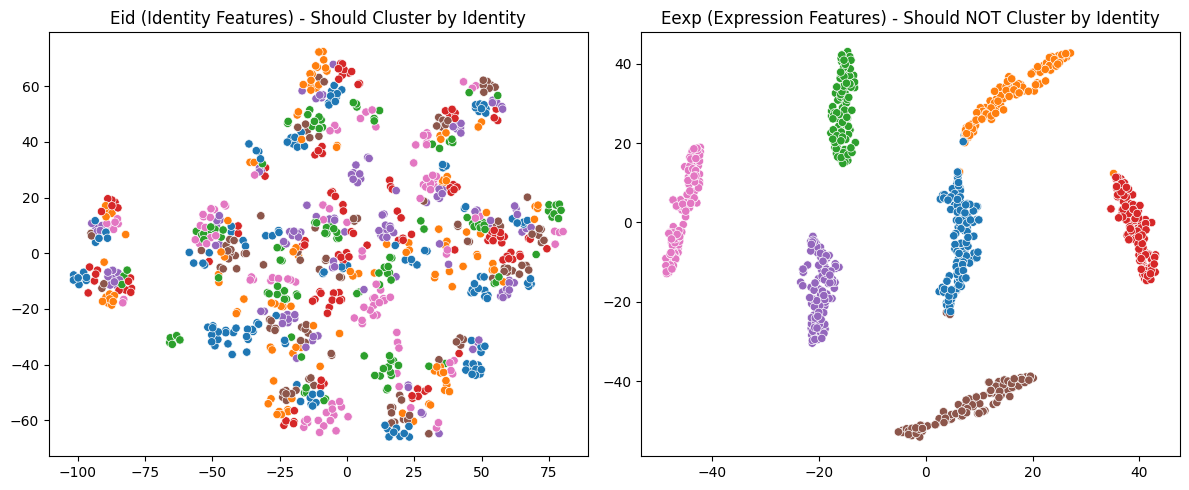

In [114]:
transform = transforms.Compose([
    transforms.Resize((112, 112)),
    transforms.ToTensor(),  # Converts to [C, H, W] with C=1
])


dataset = ExpressionPairDataset(root_dir='../Dataset/Processed_Photos', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)
test_identity_disentanglement(Eid, Eexp, dataloader, device)



In [11]:
class ExpressionClassifier(nn.Module):
    def __init__(self, input_dim=256, num_classes=7):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# class ExpressionClassifier(nn.Module):
#     def __init__(self, input_dim=256, num_classes=7):
#         super().__init__()
#         self.net = nn.Sequential(
#             nn.Linear(input_dim, 256),
#             nn.ReLU(),
#             nn.Dropout(0.4),
#             nn.Linear(256, 128),
#             nn.ReLU(),
#             nn.Dropout(0.3),
#             nn.Linear(128, num_classes)
#         )

#     def forward(self, x):
#         return self.net(x)

In [12]:
class ExpressionFolderDataset(Dataset):
    def __init__(self, root_dir, label_map, transform=None):
        self.root_dir = root_dir
        self.transform = transform or transforms.Compose([
            transforms.Resize((112, 112)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5], std=[0.5])
        ])
        self.label_map = label_map
        self.samples = []

        for expression in os.listdir(root_dir):
            expression_dir = os.path.join(root_dir, expression)
            if not os.path.isdir(expression_dir): continue
            for fname in os.listdir(expression_dir):
                if fname.lower().endswith(('.jpg', '.png', '.jpeg')):
                    self.samples.append((os.path.join(expression_dir, fname), self.label_map[expression.lower()]))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert('L')
        image = self.transform(image)
        return image, label

In [21]:
label_map = {
    'happy': 0,
    'sad': 1,
    'angry': 2,
    'surprise': 3,
    'disgust': 4,
    'fear': 5,
    'neutral': 6
}

from torch.utils.data import random_split, DataLoader

full_dataset = ExpressionFolderDataset('../Dataset/Processed_Photos', label_map)
train_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_size

train_dataset, test_dataset = random_split(full_dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Eexp = ExpressionEncoder( feature_dim=128,pretrained=False)
Eexp.load_state_dict(torch.load("expression_encoder.pth", map_location='cpu'))

Eid = IdentityEncoder(feature_dim=128)
Eid.load_state_dict(torch.load('identity_encoder.pth'))


def train_expression_classifier(Eexp, Eid, classifier, dataloader, optimizer, device=device, epochs=10):
    Eexp.eval()
    Eid.eval()
    classifier.to(device)
    classifier.train()

    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            with torch.no_grad():
                EM, _ = Eexp(images)
                _, IM = Eid(images)
                IM = IM.view(IM.size(0), -1)  # Flatten to [B, 512 * 4 * 4] = [B, 8192]


            features = torch.cat([EM, IM], dim=1)  # [B, 256]
            preds = classifier(features)

            loss = criterion(preds, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            correct += (preds.argmax(1) == labels).sum().item()
            total += labels.size(0)

        acc = 100 * correct / total
        print(f"[Epoch {epoch+1}] Loss: {total_loss:.4f} | Accuracy: {acc:.2f}%")

In [24]:
classifier = ExpressionClassifier(input_dim=8320, num_classes=len(label_map))
optimizer = torch.optim.Adam(classifier.parameters(), lr=1e-4)
train_expression_classifier(Eexp, Eid, classifier, train_loader, optimizer, epochs=150)


[Epoch 1] Loss: 78.5707 | Accuracy: 24.89%
[Epoch 2] Loss: 64.6571 | Accuracy: 48.11%
[Epoch 3] Loss: 54.1398 | Accuracy: 60.33%
[Epoch 4] Loss: 45.9794 | Accuracy: 67.57%
[Epoch 5] Loss: 38.0010 | Accuracy: 78.36%
[Epoch 6] Loss: 33.4620 | Accuracy: 82.65%
[Epoch 7] Loss: 28.2713 | Accuracy: 87.10%
[Epoch 8] Loss: 24.3725 | Accuracy: 89.37%
[Epoch 9] Loss: 21.4997 | Accuracy: 91.63%
[Epoch 10] Loss: 18.7243 | Accuracy: 93.21%
[Epoch 11] Loss: 15.9870 | Accuracy: 95.02%
[Epoch 12] Loss: 14.7077 | Accuracy: 95.63%
[Epoch 13] Loss: 12.9853 | Accuracy: 96.68%
[Epoch 14] Loss: 11.0433 | Accuracy: 98.19%
[Epoch 15] Loss: 10.1140 | Accuracy: 98.34%
[Epoch 16] Loss: 8.8489 | Accuracy: 98.72%
[Epoch 17] Loss: 8.0406 | Accuracy: 98.87%
[Epoch 18] Loss: 6.9898 | Accuracy: 99.10%
[Epoch 19] Loss: 6.2467 | Accuracy: 99.40%
[Epoch 20] Loss: 5.8486 | Accuracy: 99.32%


KeyboardInterrupt: 

In [26]:
torch.save(classifier.state_dict(), "Final.pth")

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

Eexp = ExpressionEncoder( feature_dim=128,pretrained=False)
Eexp.load_state_dict(torch.load("expression_encoder.pth", map_location='cpu'))

Eid = IdentityEncoder(feature_dim=128)
Eid.load_state_dict(torch.load('identity_encoder.pth'))
def evaluate_classifier(Eexp, Eid, classifier, dataloader, device=device):
    classifier.eval()
    Eexp.eval()
    Eid.eval()

    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            EM, _ = Eexp(images)
            _, IM = Eid(images)
            IM = IM.view(IM.size(0), -1)  # Flatten to [B, 512 * 4 * 4] = [B, 8192]
            features = torch.cat([EM, IM], dim=1)
            preds = classifier(features)

            predicted = preds.argmax(1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = 100 * correct / total
    print(f"🎯 Final Test Accuracy: {acc:.2f}%")

    return all_preds, all_labels


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
import numpy as np

def plot_confusion_matrix(preds, labels, label_names):
    cm = confusion_matrix(labels, preds)
    acc = accuracy_score(labels, preds) * 100

    cm_percent = cm.astype("float") / cm.sum(axis=1, keepdims=True) * 100
    cm_percent = np.nan_to_num(cm_percent)  # Handle division by zero

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_percent, annot=True, fmt=".1f", cmap="Blues",
                xticklabels=label_names, yticklabels=label_names)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (% row-wise) — Accuracy: {acc:.2f}%")
    plt.tight_layout()
    plt.show()


🎯 Final Test Accuracy: 97.59%


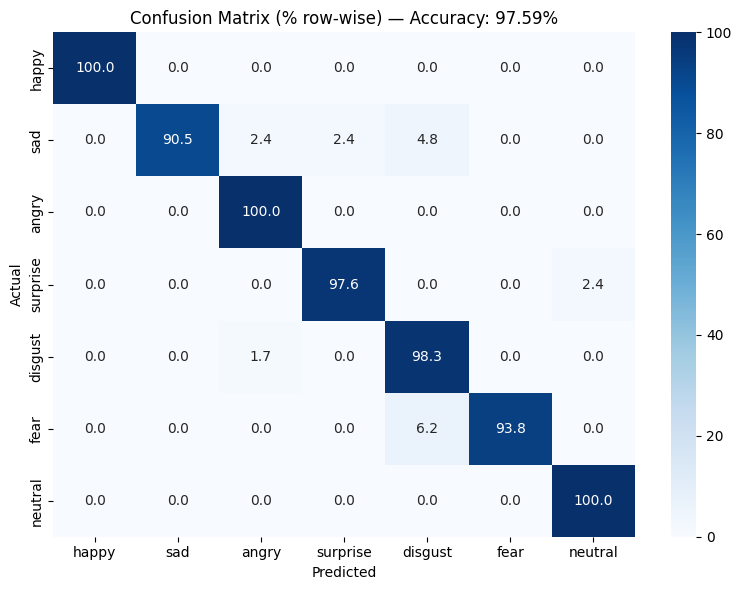

In [24]:
classifier = ExpressionClassifier(input_dim=8320, num_classes=len(label_map))
classifier.load_state_dict(torch.load("Final.pth", map_location='cpu'))
optimizer_cls = torch.optim.Adam(classifier.parameters(), lr=1e-4)

preds, labels = evaluate_classifier(Eexp, Eid, classifier, test_loader)
plot_confusion_matrix(preds, labels, list(label_map.keys()))


#### 